In [2]:
%run Classes/SPDEs.ipynb
%run Classes/Rule.ipynb
%run Classes/Model.ipynb
%run Classes/Noise.ipynb
%run Classes/full_visualization.ipynb
%run Algorithms/Algorithm_2.ipynb
%run Classes/Burgers_PDE_FIND.ipynb

In [39]:
# Uploading the data of the same solutions. Alternatively create data as in Burgers_Numerics1.ipynb

Burgers_true = pd.read_csv("Burgers_fourier", index_col=0, header = [0,1])
Burgers_true = [Burgers_true["S"+str(i)] for i in range(1, Burgers_true.columns.levshape[0]+1)]

num_samples = len(Burgers_true)

test = np.random.choice(np.arange(num_samples), int(num_samples/6), replace = False)

T, X = Burgers_true[0].index.values.astype('float32'), Burgers_true[0].columns.values.astype('float32')

for B in Burgers_true: B.columns = X

In [7]:
noise = 0.01

Burgers_noise = np.array([B+np.random.normal(scale = noise*np.abs(B).mean().mean(), size = (len(T),len(X))) for B in Burgers_true])
Burgers_noise = Burgers_noise.astype('float32')
for i in range(num_samples):
    Burgers_noise[i, :, -1] = Burgers_noise[i, :, 0]
    
Burgers_noise_df = [pd.DataFrame(B, index = T, columns = X) for B in Burgers_noise]

In [ ]:
# Double check that approximatelly 1% error is added

show = summary(test)

er_ = show.errors(Burgers_true,[Burgers_noise_df[i] for i in test])
print('')
av_er_ = show.errors(Burgers_true,[Burgers_noise_df[i] for i in test], full = False, maxi = True)

In [8]:
# Algorithm 2 on the noisy data

R = Rule(kernel_deg = 2, noise_deg = -1.5, free_num = 2)

experiment_noise = IML(Burgers_noise, Rule = R, eps = 0.1, height = 4, deg = 3, T = T, X = X) # initialize experiment for algorithm 2
experiment_noise.set_train_test(test = test) # initialize test set

experiment_noise.set_trees() # extract trees
R.exceptions = set([tree for tree in experiment_noise.trees if '2' in tree])
experiment_noise.set_trees([tree for tree in experiment_noise.trees if '2' not in tree])

experiment_noise.training_models() # Create models for Step 2 of Algorithm 2

100%|██████████| 1/1 [00:00<00:00, 51.92it/s]


99
42
Creating Model


100%|██████████| 20000/20000 [20:49<00:00, 16.00it/s] 


In [9]:
experiment_noise.fit_training_model() # Linear fit for Step 2 of Algorithm 2
experiment_noise.learn_with_fitted() # Recurcive steps 3 & 4 of Algorithm 2

100%|██████████| 20/20 [00:01<00:00, 12.64it/s]


100%|██████████| 20/20 [00:01<00:00, 14.76it/s]


In [ ]:
# Predicted values on the noisy data. Outliers that blow up during the experiment are excluded

Prediction_noise = experiment_noise_.to_df_list()

outliers = [i for i in range(len(test)) if show_prediction.one_error(i, Burgers_true, Prediction_noise) > 1]
test_no_outliers = [test[i] for i in range(len(test)) if i not in outliers]
Prediction_noise = [Prediction_noise[i] for i in range(len(test)) if i not in outliers]

print('Numerical Scheme failed for {} equation with the above coeficients.'.format(len(outliers)))

In [20]:
show_no_outliers = summary(test_no_outliers)

er_noise = show_no_outliers.errors(Burgers_true, Prediction_noise)
print('')
av_er_noise = show_no_outliers.errors(Burgers_true, Prediction_noise, full = False, maxi = True)

Total relative error for all test cases: 0.04587065164399729

Average error over all test cases: 0.06213753724521639

Maximum relative error among test cases: 0.17000891710771682


In [ ]:
# PDE-FIND with polynomial interpolation on the noisy data

# Number of equations used for the PDE-FIND algorithm
learning_samples = num_samples-len(test) 
# learning_samples = 1

u = np.array([Burgers_noise[i] for i in range(len(Burgers_noise)) if i not in test])

dt, dx = T[1]-T[0], X[1]-X[0]
# get viscosity and non linear coeficient of the Burgers equation
# Use polynomial interpolation to differentiate the noisy data
eps, lambd = PDE_FIND_Burgers(u[:learning_samples], dt, dx, diff='poly', offset_x = 10, offset_t = 10, deg_x = 5, deg_t = 5)

print("Coefficients of equation obtained from PDE-FIND regression:")
print("Viscocity coef: {}, Non-lin coef: {}.".format(eps, lambd))

In [ ]:
time_scale = 10 # increase the time interval for finer Euler scheme

T_ = np.linspace(T[0] , T[-1], time_scale*(len(T)-1)+1)

IC_ = np.array([B[0] for B in Burgers_noise])

W_ = np.zeros((num_samples, len(T_), len(X)))

Burgers_noise_FIND = SPDE(BC = 'P', IC = IC_, eps = eps).Burgers(W_, lambd = lambd, T = T_, X = X)

Burgers_noise_FIND = [pd.DataFrame(Burgers_noise_FIND[i, ::time_scale, :], index = T, columns = X) for i in test]

In [ ]:
test_without_nan = [test[i] for i in range(len(test)) if not Burgers_noise_FIND[i].isnull().values.any()]
Burgers_noise_FIND_ = [B for B in Burgers_noise_FIND if not B.isnull().values.any()]

print('Numerical Scheme failed for {} equation with the above coeficients.'.format(len(test)-len(test_without_nan)))

In [ ]:
show_FIND = summary(test_without_nan)

er_noise = show_FIND.errors(Burgers_true, Burgers_noise_FIND_)
print('')
av_er_noise = show_FIND.errors(Burgers_true, Burgers_noise_FIND_, full = False, maxi = True)

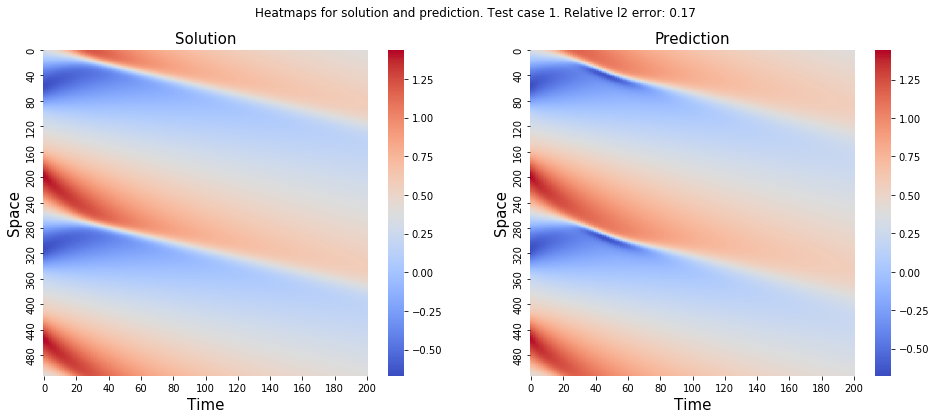

In [11]:
show_prediction.full_comparison(0, Burgers_true, Prediction_noise)

In [ ]:
show_FIND.full_comparison(0, Burgers_noise_df, Burgers_noise_FIND_)